In [1]:
from path_planning import MapReader
from path_finding import PathPlanner
import numpy as np
import json
import matplotlib.pyplot as plt
import time

In [11]:
def main():
    print("Path planning initialized...")

    mapReader = MapReader(map_fname=r'C:\Users\Public\ECE4078\project\truemap_cv.txt',search_list='test_search_list.txt')

    fruits, fruit_positions, aruco_positions = mapReader.load_map_data()
    print(fruits)

    start_x, start_y = 0, 0  # starting position

    search_targets = mapReader.read_search_list()
    goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
    print(search_targets)
    print(goals)

    planner = PathPlanner(grid_resolution=0.05, robot_radius=0.1, target_radius=6)


    for fruit in fruit_positions:
        planner.add_obstacle(fruit[0], fruit[1], 0.1)

    for ox, oy in zip(aruco_positions[:, 0],aruco_positions[:, 1]):
        planner.add_obstacle(ox, oy, 0.1)

    goal_count = 0
    show_visualization = True

    with open('waypoint.txt', 'w') as file:  # Open file once in write mode
        for goal in goals:
            goal_count += 1
            path_x, path_y = planner.plan_path(start_x, start_y, goal[0], goal[1])
            print(goal)

            if show_visualization:
                plt.plot(planner.obstacle_x, planner.obstacle_y, ".k")
                plt.plot(start_x, start_y, "og")
                plt.plot(goal[0], goal[1], "xb")
                plt.grid(True)
                plt.axis("equal")
                plt.plot(path_x, path_y, "-r")
                plt.gca().set_xticks(np.arange(-1.6, 1.6, 0.4))
                plt.gca().set_yticks(np.arange(-1.6, 1.6, 0.4))
                plt.xlim(-1.6, 1.6)
                plt.ylim(-1.6, 1.6)
                plt.show()

            # Write waypoints to file
            file.write(f"Target{goal_count}\n")
            for x, y in zip(path_x, path_y):
                file.write(f"{x},{y}\n")

            start_x, start_y = path_x[0], path_y[0]


Path planning initialized...
['redapple', 'greenapple', 'orange', 'mango', 'capsicum']
['redapple', 'greenapple', 'orange']
[array([-0.8,  0.4]), array([ 0.8, -0.4]), array([-0.8,  1.2])]
time to add obstacles 0.0
time to build grid 2.456737995147705
time to add obstacles 0.0
time to build grid 2.378774881362915
time to add obstacles 0.0
time to build grid 2.4460341930389404
time to add obstacles 0.0
time to build grid 2.602661371231079
time to add obstacles 0.0
time to build grid 2.6018316745758057
time to add obstacles 0.0
time to build grid 2.6763439178466797
time to add obstacles 0.0
time to build grid 2.707322597503662
time to add obstacles 0.0
time to build grid 2.755038022994995
time to add obstacles 0.0
time to build grid 2.819185972213745
time to add obstacles 0.0
time to build grid 2.925225257873535
time to add obstacles 0.0
time to build grid 2.9706363677978516
time to add obstacles 0.0
time to build grid 3.072626829147339
time to add obstacles 0.0
time to build grid 3.13793

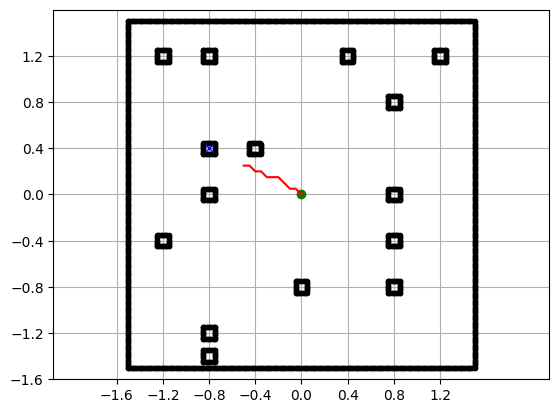

Navigation Time: 0.0
[ 0.8 -0.4]


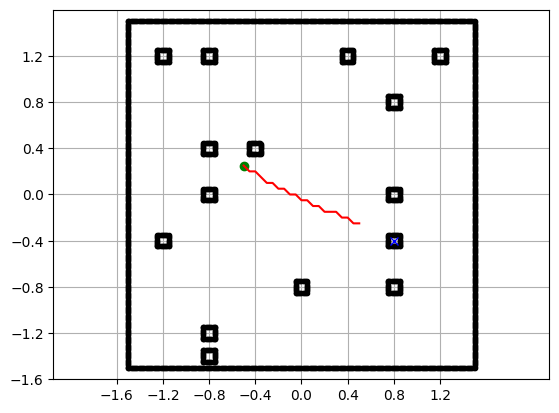

Navigation Time: 0.0
[-0.8  1.2]


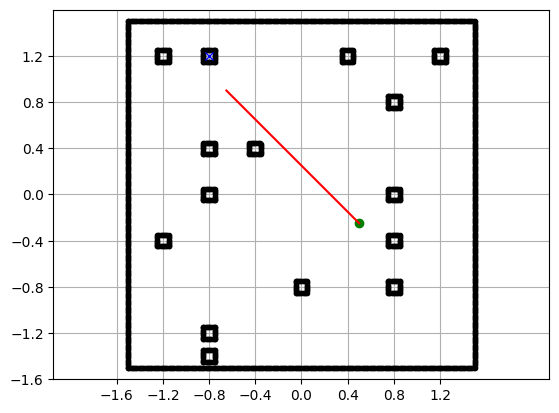

In [12]:
main()

Navigation Time: 0.0020008087158203125
[-0.8  0.4]


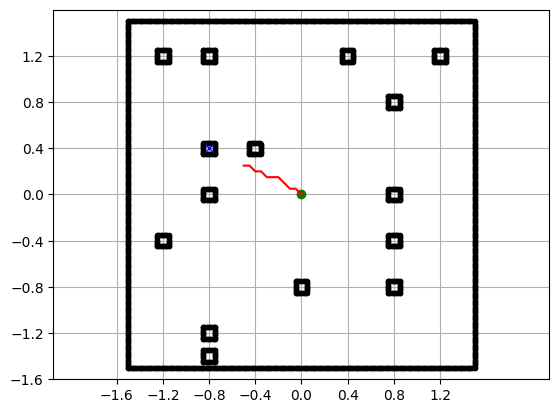

Navigation Time: 0.004205942153930664
[ 0.8 -0.4]


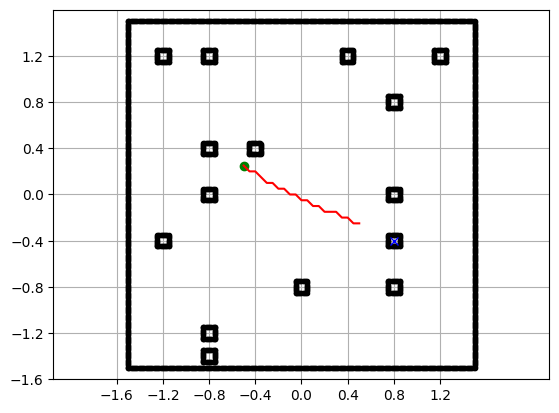

Open set is empty.


Exception: No path found

In [17]:
mapReader = MapReader(map_fname=r'C:\Users\Public\ECE4078\project\truemap_cv.txt',search_list='test_search_list.txt')
fruits, fruit_positions, aruco_positions = mapReader.load_map_data()

new_planner = PathPlanner(grid_resolution=0.05, robot_radius=0.1, target_radius=6)
new_planner.import_obstacle_grid(r"C:\Users\Public\ECE4078\project\obstacle_grid.txt")
for fruit in fruit_positions:
    new_planner.add_square_obstacle(fruit[0], fruit[1], 0.1)

for ox, oy in zip(aruco_positions[:, 0],aruco_positions[:, 1]):
    new_planner.add_square_obstacle(ox, oy, 0.1)


start_x, start_y = 0, 0  # starting position
goal_count = 0
search_targets = mapReader.read_search_list()
goals = PathPlanner.compute_goal_positions(fruits, fruit_positions, search_targets)
with open('waypoint.txt', 'w') as file:  # Open file once in write mode
    for goal in goals:
        goal_count += 1
        path_x, path_y = new_planner.plan_path(start_x, start_y, goal[0], goal[1])
        print(goal)

       
        plt.plot(new_planner.obstacle_x, new_planner.obstacle_y, ".k")
        plt.plot(start_x, start_y, "og")
        plt.plot(goal[0], goal[1], "xb")
        plt.grid(True)
        plt.axis("equal")
        plt.plot(path_x, path_y, "-r")
        plt.gca().set_xticks(np.arange(-1.6, 1.6, 0.4))
        plt.gca().set_yticks(np.arange(-1.6, 1.6, 0.4))
        plt.xlim(-1.6, 1.6)
        plt.ylim(-1.6, 1.6)
        plt.show()

        # Write waypoints to file
        file.write(f"Target{goal_count}\n")
        for x, y in zip(path_x, path_y):
            file.write(f"{x},{y}\n")

        start_x, start_y = path_x[0], path_y[0]

The purpose of this jupyter notebook is to see what is the reason behind slow calculation of algo.Besides, we could also demo the functionality of path_finding package via code above.